# Generating MNIST Digits On Demand with a Conditional GAN

This notebook provides you with a complete code example to generate specific MNIST digits on demand with a conditional GAN.

## Loading the MNIST Dataset with PyTorch

Implement the digit transformations ...

In [1]:
from torchvision import transforms as trans

transform = trans.Compose([
    trans.Resize((64, 64)), trans.ToTensor(),
    trans.Normalize(mean=[0.5], std=[0.5], inplace=True)
])

... import the MNIST digits ...

In [2]:
from torchvision.datasets import MNIST

trainset = MNIST(root="data", train=True, transform=transform, download=True)

... and plot some of the transformed MNIST digits.

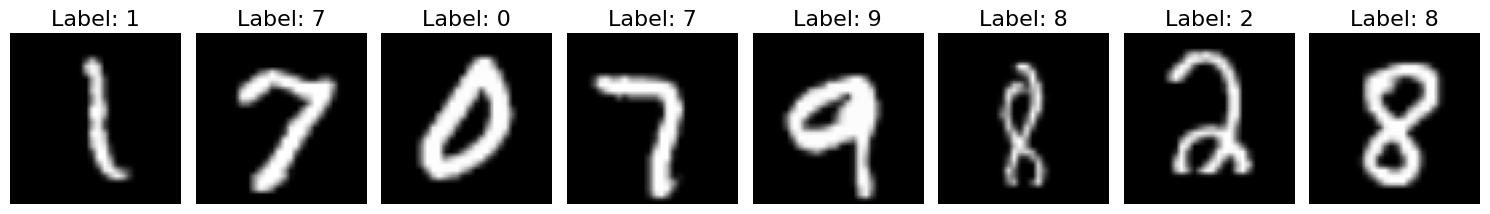

In [3]:
import torch
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 8, figsize=(15, 3))
for ax in axs.ravel():
    img, label = trainset[torch.randint(0, len(trainset), (1,)).squeeze()]
    ax.imshow(img.squeeze(), cmap="gray")
    ax.set_title(f"Label: {label}", fontsize=16)
    ax.axis("off")
plt.tight_layout()
plt.show()

## Defining the Generator and Discriminator

Determine the device to be used in the computations ...

In [4]:
def get_device():
    """Select device where to perform computations."""
    if torch.cuda.is_available():
        return torch.device("cuda:0")
    elif torch.backends.mps.is_available():
        return torch.device("mps")
    else:
        return torch.device("cpu")

device = get_device()

... instantiating the generator ...

In [5]:
import deeplay as dl

latent_dim = 100

gen = dl.DCGANGenerator(
    latent_dim=latent_dim, features_dim=64, output_channels=1,
    class_conditioned_model=True, embedding_dim=100, num_classes=10,
)
gen.build()
gen.to(device);

print(gen)

DCGANGenerator(
  (blocks): LayerList(
    (0): Conv2dBlock(
      (layer): ConvTranspose2d(200, 1024, kernel_size=(4, 4), stride=(1, 1))
      (activation): ReLU()
      (normalization): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): Conv2dBlock(
      (layer): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (activation): ReLU()
      (normalization): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): Conv2dBlock(
      (layer): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (activation): ReLU()
      (normalization): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (3): Conv2dBlock(
      (layer): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (activation): ReLU()
      (normalization): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, tr

... and instantiate the discriminator.

In [6]:
disc = dl.DCGANDiscriminator(
    input_channels=1, features_dim=64, class_conditioned_model=True, 
    embedding_dim=100, num_classes=10,
)
disc.build()
disc.to(device);

print(disc)

DCGANDiscriminator(
  (blocks): LayerList(
    (0): Conv2dBlock(
      (layer): Conv2d(2, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (activation): LeakyReLU(negative_slope=0.2)
    )
    (1): Conv2dBlock(
      (layer): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (activation): LeakyReLU(negative_slope=0.2)
      (normalization): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): Conv2dBlock(
      (layer): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (activation): LeakyReLU(negative_slope=0.2)
      (normalization): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (3): Conv2dBlock(
      (layer): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (activation): LeakyReLU(negative_slope=0.2)
      (normalization): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (

## Training the GAN

Define the data loader ...

In [7]:
from torch.utils.data import DataLoader

loader = DataLoader(trainset, batch_size=128, shuffle=True, num_workers=4)

... define the loss function ...

In [8]:
loss = torch.nn.BCELoss()

... define the optimizers ...

In [9]:
optim_gen = torch.optim.Adam(gen.parameters(), lr=0.0002, betas=(0.5, 0.999))
optim_disc = torch.optim.Adam(disc.parameters(), lr=0.0002, betas=(0.5, 0.999))

... implement the adversarial training ...

In [10]:
import time
from datetime import timedelta

epochs = 10

num_batches = len(loader)
gen_losses_avg, disc_losses_avg = [], []
fix_latent_vector = torch.randn(30, latent_dim, 1, 1).to(device)
fix_class_labels = torch.arange(0, 10).repeat(3).to(device)
for epoch in range(epochs):
    gen.train(), disc.train()
    
    print("\n" + f"Epoch {epoch + 1}/{epochs}" + "\n" + "-" * 10)
    start_time = time.time()

    running_gen_loss, running_disc_loss = 0.0, 0.0    
    for batch_idx, (real_images, class_labels) in enumerate(loader, start=0):
        real_images = real_images.to(device)
        class_labels = class_labels.to(device)

        noise = torch.randn(real_images.shape[0], latent_dim, 1, 1).to(device)
        fake_images = gen(noise, class_labels)

        # 1.  Discriminator training: minimize - log(D(x)) - log(1 - D(G(z))).
        real_output = disc(real_images, class_labels).reshape(-1)
        fake_output = disc(fake_images, class_labels).reshape(-1)

        real_loss = loss(real_output, torch.ones_like(real_output))
        fake_loss = loss(fake_output, torch.zeros_like(fake_output))

        disc_loss = (real_loss + fake_loss) / 2

        optim_disc.zero_grad()
        disc_loss.backward(retain_graph=True)
        optim_disc.step()

        # 2.  Generator training: minimize - log(D(G(z))).
        fake_output = disc(fake_images, class_labels).reshape(-1)
        gen_loss = loss(fake_output, torch.ones_like(fake_output))

        optim_gen.zero_grad()
        gen_loss.backward()
        optim_gen.step()
        
        if batch_idx % 100 == 0:
            print(f"Batch {batch_idx + 1}/{num_batches}: " 
                  + f"Generator Loss: {gen_loss.item():.4f}, " 
                  + f"Discriminator Loss: {disc_loss.item():.4f}")

        running_gen_loss += gen_loss.item()
        running_disc_loss += disc_loss.item()

    gen_losses_avg.append(running_gen_loss / num_batches)
    disc_losses_avg.append(running_disc_loss / num_batches)
    end_time = time.time()

    print("-" * 10 + "\n"
          + f"Epoch {epoch + 1}/{epochs}: " 
          + f"Generator Loss: {gen_losses_avg[-1]:.4f}, "
          + f"Discriminator Loss: {disc_losses_avg[-1]:.4f}, "
          + f"Time taken: {timedelta(seconds=end_time - start_time)}")
    
    gen.eval(), disc.eval()
    fake_images = gen(fix_latent_vector, 
                      fix_class_labels).detach().cpu().numpy()
    
    if epoch == 9:
        fig, axs = plt.subplots(3, 10, figsize=(20, 6))
        for i, ax in enumerate(axs.ravel()):
            ax.imshow(fake_images[i][0], cmap="gray")
            ax.axis("off")
        plt.tight_layout()
        plt.savefig("fig_09_A2.pdf", bbox_inches="tight")  ### plt.show()
        plt.close(fig)


Epoch 1/10
----------
Batch 1/469: Generator Loss: 0.8560, Discriminator Loss: 0.6966
Batch 101/469: Generator Loss: 3.7756, Discriminator Loss: 0.0358
Batch 201/469: Generator Loss: 1.7203, Discriminator Loss: 0.4638
Batch 301/469: Generator Loss: 1.7020, Discriminator Loss: 0.5265
Batch 401/469: Generator Loss: 1.0931, Discriminator Loss: 0.8135
----------
Epoch 1/10: Generator Loss: 1.7718, Discriminator Loss: 0.4613, Time taken: 0:04:09.683138

Epoch 2/10
----------
Batch 1/469: Generator Loss: 1.2892, Discriminator Loss: 0.5255
Batch 101/469: Generator Loss: 1.3189, Discriminator Loss: 0.4494
Batch 201/469: Generator Loss: 0.9036, Discriminator Loss: 0.5910
Batch 301/469: Generator Loss: 0.9124, Discriminator Loss: 0.5400
Batch 401/469: Generator Loss: 0.7484, Discriminator Loss: 0.5584
----------
Epoch 2/10: Generator Loss: 1.1764, Discriminator Loss: 0.5474, Time taken: 0:04:09.949202

Epoch 3/10
----------
Batch 1/469: Generator Loss: 1.3906, Discriminator Loss: 0.4408
Batch 1

## Plotting the Training Losses

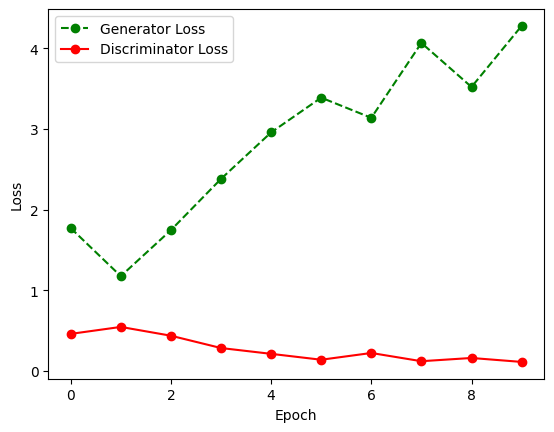

In [11]:
import numpy as np

plt.plot(np.arange(len(gen_losses_avg)), gen_losses_avg, "g--o",
         label="Generator Loss")
plt.plot(np.arange(len(disc_losses_avg)), disc_losses_avg, "r-o",
         label="Discriminator Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()
